# Close Gaps in Your Data with Smart Imputation

Dealing with datasets that contain missing values can be of challenge. In particular if the remaining non-missing values are not representative, and thus provide a distorted, biased picture of the overall population.

In this tutorial we demonstrate how MOSTLY AI can help to close such gaps in your data via "Smart Imputation". By generating a synthetic dataset, that doest not contain any missing values, it is possible to create a complete and sound representation of the underlying population. With that it is then straightforward to accurately analyze the population, as if all values were present in the first place.

For this tutorial, we will be using a modified version of the UCI Adult Income [[2](#refs)] dataset, that itself stems from the 1994 American Community Survey [[3](#refs)] by the US census bureau. This reduced dataset consists of 48,842 records and 10 mixed-type features, whereas we replaced ~28% of the values for attribute `age` with missing values. This was done randomly, but with a specified bias, so that we ended up missing the age information particularly from the elder segments. See the section on Data Preperation for details.

In [15]:
import pandas as pd
import numpy as np

# let's load the original data file, that includes missing values
try:
    from google.colab import files  # check whether we are in Google colab
    repo = 'https://github.com/mostly-ai/mostly-tutorials/raw/dev/smart-imputation'
except:
    repo = '.'

# load the original data, with missing values in place
tgt = pd.read_csv(f'{repo}/census-with-missings.csv')
print(f'read original data with {tgt.shape[0]:,} records and {tgt.shape[1]} attributes')

read original data with 48,842 records and 10 attributes


In [16]:
# let's show some samples
tgt[['workclass', 'education', 'marital-status', 'age']].sample(n=10, random_state=42)

,workclass,education,marital-status,age
7762,Private,HS-grad,Never-married,18.0
23881,Private,12th,Never-married,17.0
30507,Local-gov,HS-grad,Never-married,25.0
28911,Private,Some-college,Never-married,NaN
19484,Private,HS-grad,Never-married,47.0
43031,Private,Bachelors,Married-civ-spouse,33.0
28188,Private,HS-grad,Married-civ-spouse,38.0
12761,Private,11th,Married-civ-spouse,21.0
40834,Private,Assoc-acdm,Divorced,NaN
27875,Private,HS-grad,Married-civ-spouse,55.0


In [17]:
# report share of missing values for column `age`
print(f"{tgt['age'].isna().mean():.1%} of values for column `age` are missing")

28.5% of values for column `age` are missing


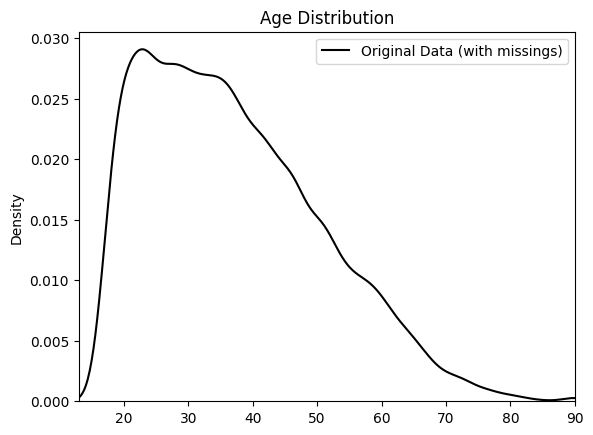

In [18]:
# plot distribution of column `age`
import matplotlib.pyplot as plt
tgt.age.plot(kind='kde', label = 'Original Data (with missings)', color='black')
_ = plt.legend(loc='upper right')
_ = plt.title('Age Distribution')
_ = plt.xlim(13, 90)
_ = plt.ylim(0, None)

## Synthesize Data via MOSTLY AI

1. Download `census-with-missings.csv` by clicking [here](https://github.com/mostly-ai/mostly-tutorials/raw/dev/smart-imputation/census-with-missings.csv) and pressing Ctrl+S to save the file locally.

2. Synthesize `census-with-missings.csv` via [MOSTLY AI](https://mostly.ai/). Leave all settings at their default, but activate the **Smart Imputation** for column **age**.

<img src='https://raw.githubusercontent.com/mostly-ai/mostly-tutorials/dev/smart-imputation/screen1.png' width="400px"/> <img src='https://raw.githubusercontent.com/mostly-ai/mostly-tutorials/dev/smart-imputation/screen2.png' width="400px"/>

3. Once the job has finished, download the generated synthetic data as CSV file to your computer, and rename it to `census-synthetic.csv`. Optionally, you can also download a previously synthesized version [here](https://github.com/mostly-ai/mostly-tutorials/raw/dev/smart-imputation/census-synthetic.csv).

4. Upload the generated synthetic data to this Notebook via executing the next cell.

5. In addition, you can also already check the distribution based on the Model QA and Data QA reports. The Model QA reports on the accuracy and privacy of the trained Generative AI model. As one can see, the distributiosn are faithfully learned, and also include the right share of missing values. The Data QA visualizes then the distributions of the delivered synthetic dataset. And there we can see, that the share of missing values (`N/A`) has dropped to 0%, and that the distribution has been shifted towards older age buckets.

<img src='https://raw.githubusercontent.com/mostly-ai/mostly-tutorials/dev/smart-imputation/screen3.png' width="400px"/> <img src='https://raw.githubusercontent.com/mostly-ai/mostly-tutorials/dev/smart-imputation/screen4.png' width="400px"/>

In [19]:
# upload synthetic dataset
import pandas as pd
try:
    # check whether we are in Google colab
    from google.colab import files
    import io
    uploaded = files.upload()
    syn = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))
    print(f"uploaded synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")
except:
    syn_file_path = f'{repo}/census-synthetic.csv'
    print(f"read synthetic data from {syn_file_path}")
    syn = pd.read_csv(syn_file_path)
    print(f"read synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")

read synthetic data from ./census-synthetic.csv
read synthetic data with 48,842 records and 10 attributes


In [20]:
# show some synthetic samples
syn[['workclass', 'education', 'marital-status', 'age']].sample(n=10, random_state=42)

,workclass,education,marital-status,age
7762,?,HS-grad,Widowed,79
23881,Private,Some-college,Married-civ-spouse,56
30507,State-gov,Some-college,Divorced,57
28911,Private,Assoc-voc,Never-married,30
19484,Private,5th-6th,Never-married,39
43031,Self-emp-not-inc,Masters,Married-civ-spouse,41
28188,Self-emp-not-inc,11th,Divorced,37
12761,Self-emp-not-inc,Bachelors,Married-civ-spouse,33
40834,State-gov,Some-college,Married-civ-spouse,28
27875,Private,Assoc-acdm,Married-civ-spouse,38


In [21]:
# report share of missing values for column `age`
print(f"{syn['age'].isna().mean():.1%} of values for column `age` are missing")

0.0% of values for column `age` are missing


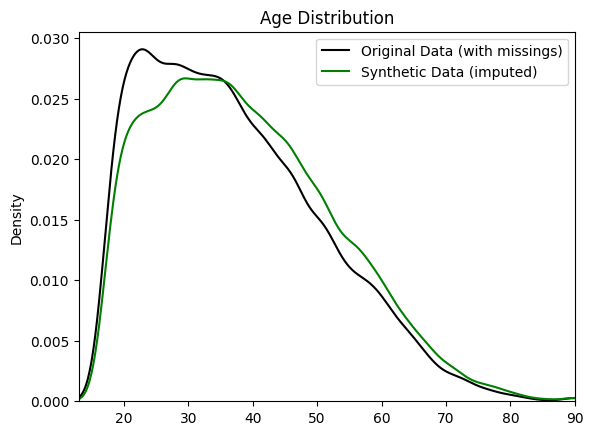

In [22]:
# plot side-by-side
import matplotlib.pyplot as plt
tgt.age.plot(kind='kde', label = 'Original Data (with missings)', color='black')
syn.age.plot(kind='kde', label = 'Synthetic Data (imputed)', color='green')
_ = plt.title('Age Distribution')
_ = plt.legend(loc='upper right')
_ = plt.xlim(13, 90)
_ = plt.ylim(0, None)

As one can see, the imputed synthetic data does NOT contain any missing values anymore. But it's also apparent, that the synthetic age distribution is significantly distinct from the distribution of the non-missing values that were provided.

So, let's then check, whether that new distribution is more representative of the ground truth, i.e. the underlying original age distribution.

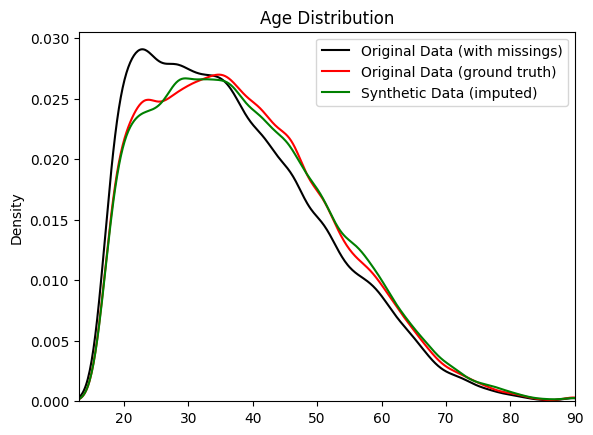

In [23]:
raw = pd.read_csv(f'{repo}/census-ground-truth.csv')

# plot side-by-side
import matplotlib.pyplot as plt
tgt.age.plot(kind='kde', label = 'Original Data (with missings)', color='black')
raw.age.plot(kind='kde', label = 'Original Data (ground truth)', color='red')
syn.age.plot(kind='kde', label = 'Synthetic Data (imputed)', color='green')
_ = plt.title('Age Distribution')
_ = plt.legend(loc='upper right')
_ = plt.xlim(13, 90)
_ = plt.ylim(0, None)

## Conclusion

As we can see, the smartly imputed synthetic data is perfectly able to recover the original, suppressed distribution! As an analyst you can proceed with the exploratory and descriptive analysis, as if the values were present in the first place.

## Further Reading

See also here for a benchmark of Smart Imputation with respect to other commonly used imputation techniques: https://mostly.ai/blog/smart-imputation-with-synthetic-data

## Extras: Data Preparation for this Tutorial

We artificially injected missing values into the original data via the following code.

In [10]:
import pandas as pd
import numpy as np

df = pd.read_csv('census-ground-truth.csv')

def mask(prob, col=None, values=None):
    is_masked = np.random.uniform(size=df.shape[0]) < prob
    if col:
        is_masked = (is_masked) & (df[col].isin(values))
    df['age'] = df['age'].mask(is_masked)

np.random.seed(123)
mask(0.1)
mask(0.6, 'education', ['Doctorate', 'Prof-school', 'Masters'])
mask(0.6, 'marital-status', ['Widowed', 'Divorced'])
mask(0.6, 'occupation', ['Exec-managerial'])
df.to_csv('census-with-missings.csv', index=False)